In [25]:
import numpy as np
import pandas as pd
import os
import warnings; warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

# initial import (monthly and annual data)
df_monthly = pd.read_csv('/Users/alexanderblaies/Desktop/python-virtual-environments/2nd_Capstone_Repo/data/raw/London_Real_Estate_Data/housing_in_london_monthly_variables.csv')

# showcasing the datatypes of each column for the monthly csv file; also, changing the date column into date-time format
df_monthly['date'] = pd.to_datetime(df_monthly['date'])
# breaking out the date-time column into month and year for an easier analysis
df_monthly['year'] = pd.DatetimeIndex(df_monthly['date']).year
df_monthly['month'] = pd.DatetimeIndex(df_monthly['date']).month
df_monthly.info()
print(df_monthly.shape)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13549 entries, 0 to 13548
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           13549 non-null  datetime64[ns]
 1   area           13549 non-null  object        
 2   average_price  13549 non-null  int64         
 3   code           13549 non-null  object        
 4   houses_sold    13455 non-null  float64       
 5   no_of_crimes   7439 non-null   float64       
 6   borough_flag   13549 non-null  int64         
 7   year           13549 non-null  int64         
 8   month          13549 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4), object(2)
memory usage: 952.8+ KB
(13549, 9)


In [26]:
# 1) let's look at the completness of the monthly data first 
total_missing_monthly = df_monthly.isnull().sum()
total_missing_percentage_monthly = df_monthly.isnull().mean() * 100
missing_monthly = pd.DataFrame({'count':total_missing_monthly, '%':total_missing_percentage_monthly})
missing_monthly.head(20)

,count,%
date,0,0.000000
area,0,0.000000
average_price,0,0.000000
code,0,0.000000
houses_sold,94,0.693778
no_of_crimes,6110,45.095579
borough_flag,0,0.000000
year,0,0.000000
month,0,0.000000


In [27]:
# based on the missing data in the 'no_of_crimes' column, it makes sense to look a little bit deeper
# Based on the below, if I break out the non boroughs from the boroughs, we may be able to leverage the crime data
crimes_agg = df_monthly.groupby(['area'])['no_of_crimes'].sum()
crimes_agg.head(40).sort_values(ascending = True)

area
england                        0.0
south west                     0.0
london                         0.0
south east                     0.0
inner london                   0.0
north east                     0.0
north west                     0.0
outer london                   0.0
east midlands                  0.0
east of england                0.0
city of london                47.0
kingston upon thames      227120.0
richmond upon thames      238531.0
sutton                    246911.0
merton                    276773.0
harrow                    287761.0
bexley                    297576.0
havering                  350452.0
barking and dagenham      366234.0
kensington and chelsea    419808.0
hammersmith and fulham    438461.0
redbridge                 444370.0
bromley                   462610.0
hounslow                  467213.0
enfield                   475844.0
hillingdon                490465.0
greenwich                 493472.0
barnet                    521763.0
lewisham       

In [28]:
# 2) additional review of the monthly dataframe to determine if the "area" section is inclusive of all boroughs in focus (33)
df_monthly.head(5)
df_monthly[df_monthly['borough_flag'] == 1]['area'].nunique()


33

In [29]:
# it looks like we have 1 borough too many, as there should only be 32; what about the other non boroughs? Let's separate these out
# reviewing to see which "borough" was not classified correctly and breaking into two dataframes (non boroughs and boroughs)
b_test = df_monthly['borough_flag'] == 1
df_monthly_b = df_monthly[b_test]
df_monthly_nonb = df_monthly[~b_test]
print(df_monthly_b.area.unique()) 


['city of london' 'barking and dagenham' 'barnet' 'bexley' 'brent'
 'bromley' 'camden' 'croydon' 'ealing' 'enfield' 'tower hamlets'
 'greenwich' 'hackney' 'hammersmith and fulham' 'haringey' 'harrow'
 'havering' 'hillingdon' 'hounslow' 'islington' 'kensington and chelsea'
 'kingston upon thames' 'lambeth' 'lewisham' 'merton' 'newham' 'redbridge'
 'richmond upon thames' 'southwark' 'sutton' 'waltham forest' 'wandsworth'
 'westminster']


In [30]:
# it appears as though the 'city of london' is not classified correctly, so let's go ahead and account for that 
extract_city = df_monthly_b[df_monthly_b['area'] == 'city of london']
print(extract_city.head(4))
print(extract_city.shape)
# looks good for extraction

        date            area  average_price       code  houses_sold  \
0 1995-01-01  city of london          91449  E09000001         17.0   
1 1995-02-01  city of london          82203  E09000001          7.0   
2 1995-03-01  city of london          79121  E09000001         14.0   
3 1995-04-01  city of london          77101  E09000001          7.0   

   no_of_crimes  borough_flag  year  month  
0           NaN             1  1995      1  
1           NaN             1  1995      2  
2           NaN             1  1995      3  
3           NaN             1  1995      4  
(301, 9)


In [31]:
# deleting the city_of_london data from the monthly_b dataframe
df_monthly_b.drop(extract_city.index, inplace = True)
print(df_monthly_b.area.unique())
print(df_monthly_b.shape)

['barking and dagenham' 'barnet' 'bexley' 'brent' 'bromley' 'camden'
 'croydon' 'ealing' 'enfield' 'tower hamlets' 'greenwich' 'hackney'
 'hammersmith and fulham' 'haringey' 'harrow' 'havering' 'hillingdon'
 'hounslow' 'islington' 'kensington and chelsea' 'kingston upon thames'
 'lambeth' 'lewisham' 'merton' 'newham' 'redbridge' 'richmond upon thames'
 'southwark' 'sutton' 'waltham forest' 'wandsworth' 'westminster']
(9635, 9)


In [32]:
# appending the city of london data to the the df_monthly_nonb dataframe
df_monthly_nonb = df_monthly_nonb.append(extract_city)
print(df_monthly_nonb.area.unique())
print(df_monthly_nonb.shape)
# adding the 3914 + 9635 = 13549; this summation indicates that all records are accounted for

['south east' 'inner london' 'outer london' 'north east' 'north west'
 'yorks and the humber' 'east midlands' 'west midlands' 'east of england'
 'london' 'south west' 'england' 'city of london']
(3914, 9)


In [33]:
# 3) based on the above, it appears as though the no_of_crimes data might be sufficient/complete for boroughs; for non boroughs, it appears as though this data isn't relevant
# let's go ahead and drop the crime data from the df_monthly_nonb dataframe
del df_monthly_nonb['no_of_crimes']
print(df_monthly_nonb.shape)
print(df_monthly_b.shape)

(3914, 8)
(9635, 9)


In [34]:
# 4) now, it's time to start looking at the features in the monthly_b dataframe more carefully; let's get a better understanding of each feature's statistical distribution profile 
# I have decided to put the non-borough df to the side for potential analysis later on; moving forward, this analysis will be exclusively around the borough data
df_monthly_b.describe().T
# based on the profile below, it appears as though we are missing a decent chunk of 'no_of_crimes' data points

,count,mean,std,min,25%,50%,75%,max
average_price,9635.0,292722.841100,196431.300891,50460.0,162699.00,249511.0,374482.50,1463378.0
houses_sold,9568.0,326.427048,137.769332,48.0,224.00,305.0,408.00,1073.0
no_of_crimes,7328.0,2191.039028,868.605751,692.0,1650.75,2144.0,2591.25,7461.0
borough_flag,9635.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0
year,9635.0,2007.039958,7.239458,1995.0,2001.00,2007.0,2013.00,2020.0
month,9635.0,6.480540,3.461150,1.0,3.00,6.0,9.00,12.0


In [35]:
# remember that there was some missing "houses_sold" and "no_of_crimes" data; let's go ahead and review that first
total_missing_monthly_b = df_monthly_b.isnull().sum()
total_missing_percentage_monthly_b = df_monthly_b.isnull().mean() * 100
missing_monthly_b = pd.DataFrame({'count':total_missing_monthly_b, '%':total_missing_percentage_monthly_b})
missing_monthly_b.head(20)

,count,%
date,0,0.000000
area,0,0.000000
average_price,0,0.000000
code,0,0.000000
houses_sold,67,0.695381
no_of_crimes,2307,23.943954
borough_flag,0,0.000000
year,0,0.000000
month,0,0.000000


In [36]:
# 5) time to account for the missing values; for both no_of_crimes and houses_sold, it makes sense to use linear interpolation in this case
df_monthly_b.houses_sold.interpolate(method = 'linear', inplace = True)
df_monthly_b.no_of_crimes.interpolate(method = 'linear', limit_direction = 'both', inplace = True)

# confirming that there are no remaining null values
print(df_monthly_b['houses_sold'].isnull().sum())
print(df_monthly_b['no_of_crimes'].isnull().sum())

# based on the statistical distributions shown in the graphs in the next cell below, the method of imputation is sufficient

0
0


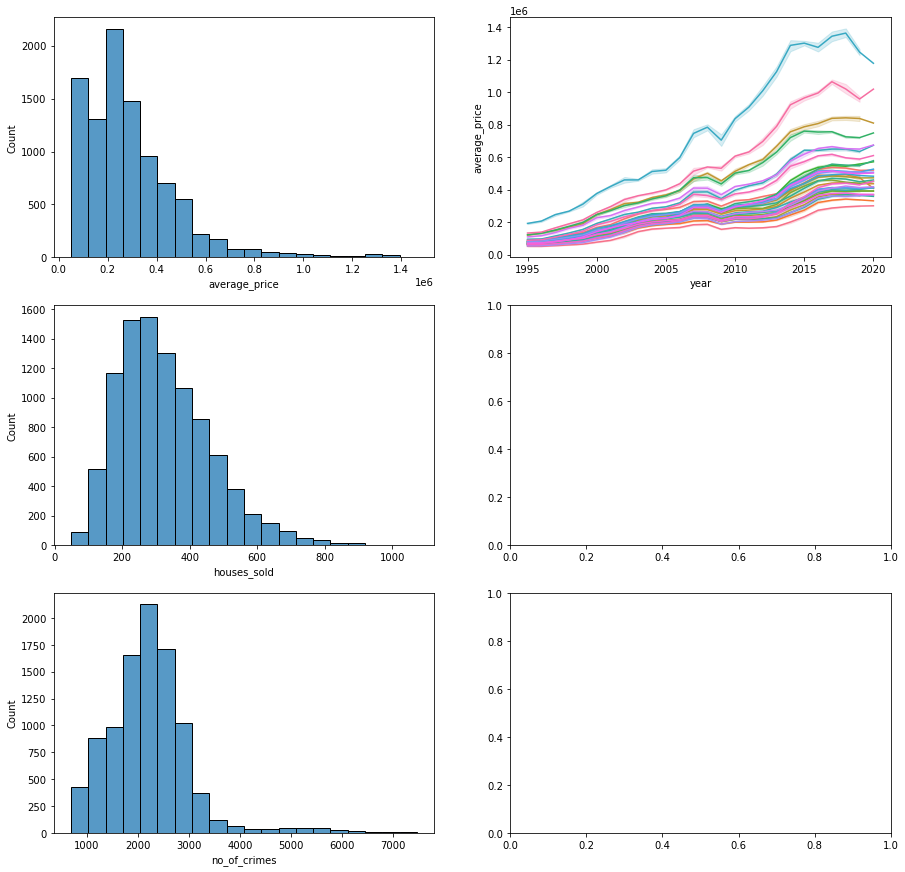

In [37]:
# reviewing the distributions of each feature
fig, axes = plt.subplots(3, 2, figsize = (15,15), sharex = False, sharey = False)

sns.histplot(x = df_monthly_b['average_price'], bins = 20, ax = axes[0,0])
sns.histplot(x = df_monthly_b['houses_sold'], bins = 20, ax = axes[1,0])
sns.histplot(x = df_monthly_b['no_of_crimes'], bins = 20, ax = axes[2,0])

sns.lineplot(ax = axes[0,1], data = df_monthly_b, x = "year", y = "average_price", hue = "area", legend = False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

#sns.lineplot(ax = axes[1,1], data = df_monthly_b, x = "year", y = "houses_sold", hue = "area", legend = False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
#plt.show()

#sns.lineplot(ax = axes[2,1], data = df_monthly_b, x = "year", y = "no_of_crimes", hue = "area", legend = False)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
#plt.show()

# the features in focus(average price, houses sold and no_of_crimes) have a nice, deviated/postively-skewed bell curve with a long tail

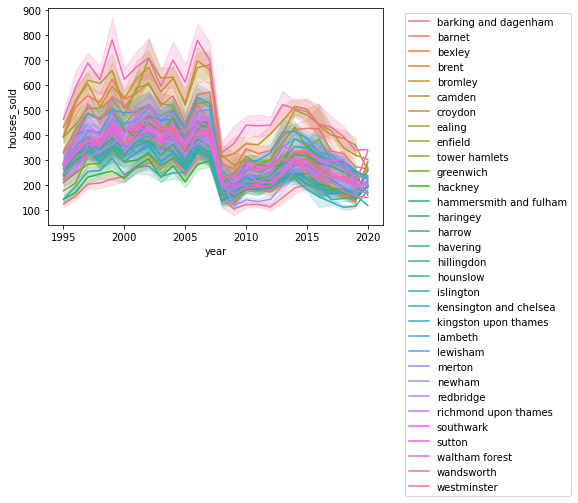

In [38]:
# for some reason this plot would not populate in the subplots above
sns.lineplot(data = df_monthly_b, x = "year", y = "houses_sold", hue = "area", legend = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

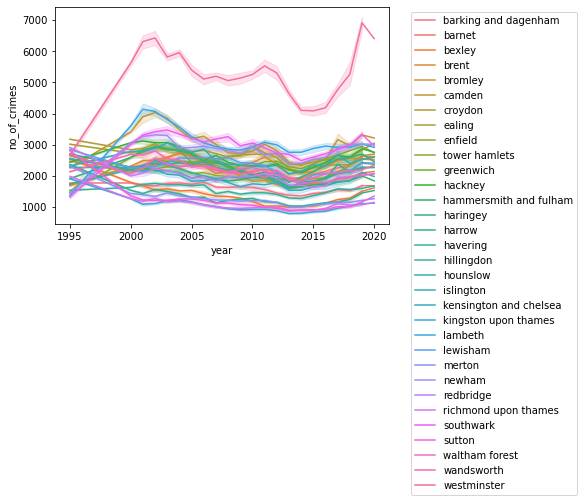

In [39]:
# for some reason this plot would not populate in the subplots above
sns.lineplot(data = df_monthly_b, x = "year", y = "no_of_crimes", hue = "area", legend = True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
plt.show()

In [40]:
# revisiting some of the statistics 
df_monthly_b.describe().T

,count,mean,std,min,25%,50%,75%,max
average_price,9635.0,292722.841100,196431.300891,50460.0,162699.0,249511.0,374482.5,1463378.0
houses_sold,9635.0,325.683757,137.639642,48.0,223.0,304.0,408.0,1073.0
no_of_crimes,9635.0,2219.829580,812.766772,692.0,1740.0,2198.0,2591.0,7461.0
borough_flag,9635.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
year,9635.0,2007.039958,7.239458,1995.0,2001.0,2007.0,2013.0,2020.0
month,9635.0,6.480540,3.461150,1.0,3.0,6.0,9.0,12.0
